## Test Model on Held-Out Subjects
This notebook applies the previously calculated model, using 10 test subjects, to the remaining 5 subjects from the same dataset that were not used at all to estimate the model. The same filters to eliminate mislabeled samples in the training data are applied to the holdout data.  

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import itertools



Using TensorFlow backend.


### Find and drop mislabeled samples for validation data (held-out 5 subjects)

In [15]:
# read in validation data
thigh_validate = pd.read_pickle('./data/thigh_validate100.pkl')

In [16]:
deviation = thigh_validate.groupby(['activity','subject','sample_num']).std()
deviation.reset_index(inplace=True)  # converts multiindex into columns

In [17]:
def find_bad_samples(df,activity,samples_to_drop,operator,threshold):
    mask =(df.activity == activity) & operator(df.attr_x_acc, threshold)
    return samples_to_drop.extend(list(df.sample_num[mask]))

In [18]:
import operator
samples_to_drop = []
find_bad_samples(deviation,'climbingdown',samples_to_drop,operator.lt,1.2)
find_bad_samples(deviation,'climbingup',samples_to_drop,operator.lt,1.2)
find_bad_samples(deviation,'jumping',samples_to_drop,operator.lt,3.5)
find_bad_samples(deviation,'lying',samples_to_drop,operator.gt,0.5)
find_bad_samples(deviation,'running',samples_to_drop,operator.lt,5)
find_bad_samples(deviation,'sitting',samples_to_drop,operator.gt,1)
find_bad_samples(deviation,'walking',samples_to_drop,operator.lt,1.5)

In [19]:
thigh_validate_clean = thigh_validate[~thigh_validate.sample_num.isin(samples_to_drop)]

In [20]:
thigh_validate_clean.to_pickle('./data/thigh_validate_clean.pkl')

## Calculate summary features grouped by window

In [5]:
def Range(x):
    return x.max() - x.min()

In [21]:
# calculate range, mean, sd for each sample
ranges = thigh_validate_clean.groupby(['activity','subject','sample_num']).apply(Range).add_prefix('range_')
means = thigh_validate_clean.groupby(['activity','subject','sample_num']).mean().add_prefix('mean_')
st_devs = thigh_validate_clean.groupby(['activity','subject','sample_num']).std().add_prefix('std_')

In [22]:
# combine range, mean, sd and save summary df
df = pd.concat([st_devs,means,ranges],axis=1)
df.reset_index(inplace=True)
df.to_pickle('./data/thigh_validate_summary.pkl')

### Predict activity classes using Logistic Regression model

In [9]:
df = pd.read_pickle('./data/thigh_validate_summary.pkl')

In [19]:
# create X and y
columns=['std_attr_x_gyr', 'std_attr_y_gyr', 'std_attr_z_gyr',
         'std_attr_x_acc', 'std_attr_y_acc', 'std_attr_z_acc', 
         'mean_attr_x_gyr', 'mean_attr_y_gyr', 'mean_attr_z_gyr', 
         'mean_attr_x_acc', 'mean_attr_y_acc', 'mean_attr_z_acc',
         'range_attr_x_gyr', 'range_attr_y_gyr','range_attr_z_gyr', 
         'range_attr_x_acc', 'range_attr_y_acc', 'range_attr_z_acc']
X = df[columns]
y = df.activity.replace({'sitting':'0_sedentary','standing':'0_sedentary','walking':'1_light_moderate','lying':'0_sedentary',
                              'climbingup':'1_light_moderate','running':'2_vigorous','climbingdown':'1_light_moderate','jumping':'2_vigorous'})

In [20]:
# read previously saved logistic regression model
pkl_filename = "./data/LR_model.pkl"  
model = pickle.load(open(pkl_filename, 'rb'))

In [21]:
# generate predictions and calculate F1, accuracy
y_pred = model.predict(X)
print(f'Validation F1 score is: {f1_score(y,y_pred,average="macro"):.3f}')
print(f'Validation acc score is: {accuracy_score(y,y_pred):.3f}')      

Validation F1 score is: 0.948
Validation acc score is: 0.938


In [22]:
# get accuracy measures per class
print(classification_report(y, y_pred))

                  precision    recall  f1-score   support

     0_sedentary       0.89      1.00      0.94      4728
1_light_moderate       1.00      0.83      0.91      3614
      2_vigorous       1.00      1.00      1.00      1551

        accuracy                           0.94      9893
       macro avg       0.96      0.94      0.95      9893
    weighted avg       0.94      0.94      0.94      9893



In [23]:
# source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='YlOrRd'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(12,8),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

<Figure size 432x288 with 0 Axes>

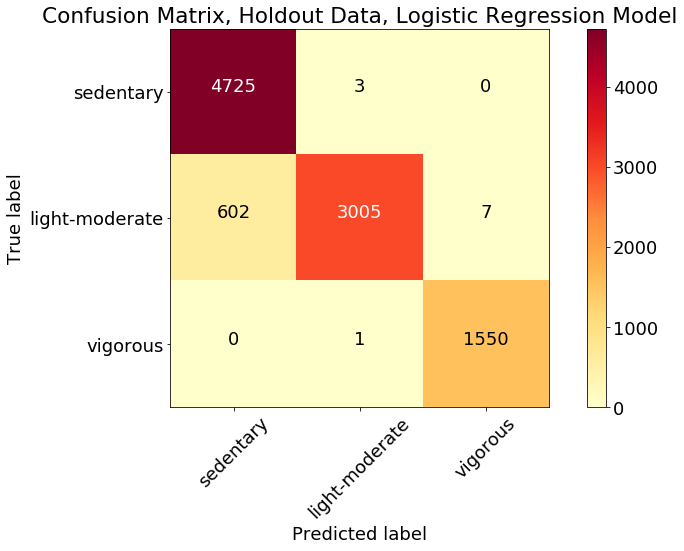

In [25]:
# plot confusion matrix
np.set_printoptions(precision=2)
cm = confusion_matrix(y, 
                      y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, 
                      classes=['sedentary','light-moderate','vigorous'],
                      title='Confusion Matrix, Holdout Data, Logistic Regression Model');


## Same model with just accelerometer

In [13]:
# create X and y
columns=[
#     'std_attr_x_gyr', 'std_attr_y_gyr', 'std_attr_z_gyr',
         'std_attr_x_acc', 'std_attr_y_acc', 'std_attr_z_acc', 
#          'mean_attr_x_gyr', 'mean_attr_y_gyr', 'mean_attr_z_gyr', 
         'mean_attr_x_acc', 'mean_attr_y_acc', 'mean_attr_z_acc',
#          'range_attr_x_gyr', 'range_attr_y_gyr','range_attr_z_gyr', 
         'range_attr_x_acc', 'range_attr_y_acc', 'range_attr_z_acc']
X = df[columns]
y = df.activity.replace({'sitting':'0_sedentary','standing':'0_sedentary','walking':'1_light_moderate','lying':'0_sedentary',
                              'climbingup':'1_light_moderate','running':'2_vigorous','climbingdown':'1_light_moderate','jumping':'2_vigorous'})

In [11]:
# read previously saved logistic regression model
pkl_filename = "./data/LR_model_acc.pkl"  
model = pickle.load(open(pkl_filename, 'rb'))

In [14]:
# generate predictions and calculate F1, accuracy
y_pred = model.predict(X)
print(f'Validation F1 score is: {f1_score(y,y_pred,average="macro"):.3f}')
print(f'Validation acc score is: {accuracy_score(y,y_pred):.3f}')      

Validation F1 score is: 0.947
Validation acc score is: 0.938


In [15]:
# get accuracy measures per class
print(classification_report(y, y_pred))

                  precision    recall  f1-score   support

     0_sedentary       0.89      1.00      0.94      4728
1_light_moderate       1.00      0.83      0.91      3614
      2_vigorous       0.99      1.00      0.99      1551

        accuracy                           0.94      9893
       macro avg       0.96      0.94      0.95      9893
    weighted avg       0.94      0.94      0.94      9893



<Figure size 432x288 with 0 Axes>

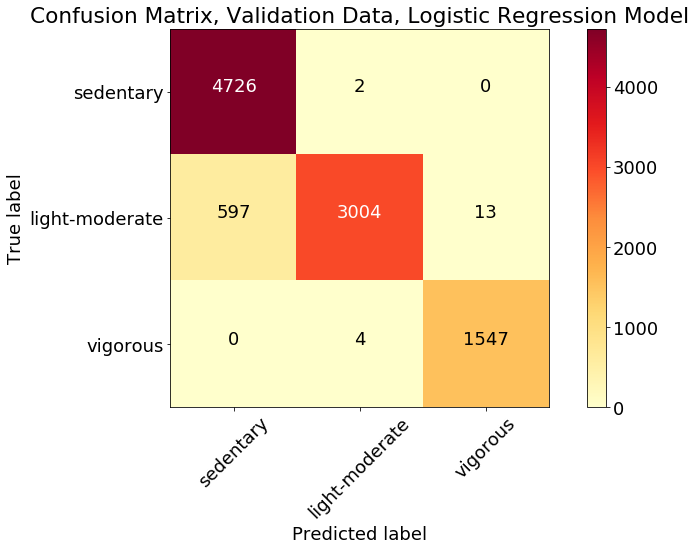

In [17]:
# plot confusion matrix
np.set_printoptions(precision=2)
cm = confusion_matrix(y, 
                      y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, 
                      classes=['sedentary','light-moderate','vigorous'],
                      title='Confusion Matrix, Holdout Data, Logistic Regression Model');
